In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
img = cv2.imread('new.png', 0)
imsize = img.shape
imsize

(512, 512)

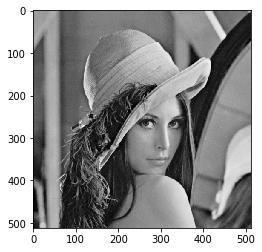

In [3]:
plt.imshow(img, cmap='gray')

In [57]:
def calc_psnr(noisy, img):
    rmse = np.sqrt(((noisy - img)**2).mean())
    psnr_db = 20*np.log10(255./rmse)
    return psnr_db

In [110]:
def wiener_filter(noisy,size,noisy_var):
    imsize = noisy.shape
    padded = np.pad(noisy,((size//2,size//2),(size//2,size//2)),'constant')
    result = np.zeros(imsize)
    for i in range(imsize[0]):
        for j in range(imsize[1]):
            local_patch = padded[(i+size//2)-size//2:(i+size//2)+size//2+1,(j+size//2)-size//2:(j+size//2)+size//2+1]
            local_mean = np.mean(local_patch)
            local_var = np.var(local_patch)
            result[i,j] = (((padded[(i+size//2),(j+size//2)]-local_mean)*local_var)/(local_var+noise_var))+local_mean
    np.clip(result,0,255,out=result) 
    return result

In [111]:
def adaptive_wiener_filter(noisy,size, noisy_var):
    imsize = noisy.shape
    padded = np.pad(noisy,((size//2,size//2),(size//2,size//2)),'constant')
    result = np.zeros(imsize)
    a = 10
    epsilon_squared = 6.25 * noise_var
    for i in range(imsize[0]):
        for j in range(imsize[1]):
            local_patch = padded[(i+size//2)-size//2:(i+size//2)+size//2+1,(j+size//2)-size//2:(j+size//2)+size//2+1]
            weight_patch = 1/(1+a*np.maximum(epsilon_squared, np.square(local_patch-padded[(i+size//2),(j+size//2)])))
            normalized_weight_patch = weight_patch/np.sum(weight_patch)
            local_mean = np.sum(normalized_weight_patch*local_patch)
            local_var = np.sum(normalized_weight_patch*np.square(local_patch-local_mean))
            result[i,j] = (((padded[(i+size//2),(j+size//2)]-local_mean)*local_var)/(local_var+noise_var))+local_mean
    np.clip(result,0,255,out=result)    
    return result

In [112]:
noise_std = 0.45*img.std()
noise_var = noise_std**2
noisy = img + noise_std* np.random.standard_normal(img.shape)
noise_var

408.28021072964674

In [113]:
calc_psnr(noisy,img)

22.017990325943622

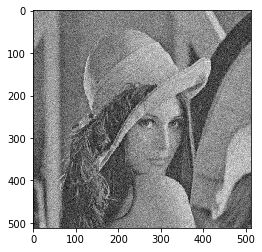

In [117]:
plt.imshow(noisy, cmap='gray')

In [120]:
wiener_filtered = wiener_filter(noisy,15, noise_var)

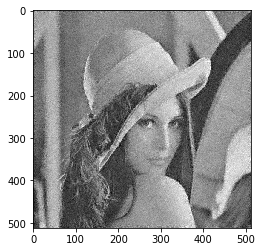

In [121]:
plt.imshow(wiener_filtered, cmap='gray')

In [122]:
calc_psnr(wiener_filtered,img)

25.54533382364728

In [123]:
adaptive_wiener_filtered = adaptive_wiener_filter(noisy,15,noise_var)

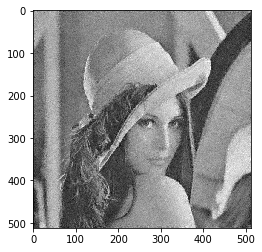

In [124]:
plt.imshow(adaptive_wiener_filtered, cmap='gray')

In [125]:
calc_psnr(adaptive_wiener_filtered,img)

25.688464525469676

In [126]:
import pywt

In [127]:
coeffs2 = pywt.dwt2(noisy, 'haar')

In [136]:
result = []
for i in range(3):
    result.append(wiener_filter(coeffs2[1][i],15,noise_var))
# result.append(coeffs2[1][2])

In [139]:
reconstruct = pywt.idwt2((coeffs2[0],tuple(result)),'haar')

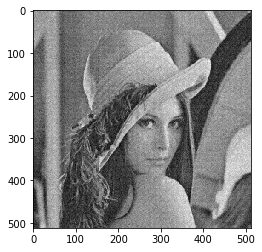

In [140]:
plt.imshow(reconstruct,cmap='gray')

In [141]:
calc_psnr(reconstruct,img)

25.952567629781282

In [142]:
aresult = []
for i in range(3):
    aresult.append(adaptive_wiener_filter(coeffs2[1][i],15,noise_var))

In [143]:
areconstruct = pywt.idwt2((coeffs2[0],tuple(aresult)),'haar')

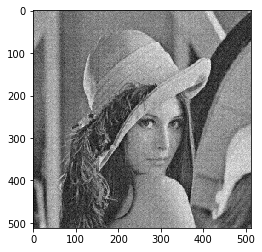

In [144]:
plt.imshow(areconstruct,cmap='gray')

In [146]:
calc_psnr(areconstruct,img)

25.953779367490295

In [147]:
combined = 0.6*areconstruct + 0.4*adaptive_wiener_filtered

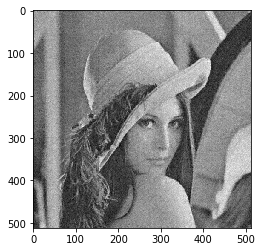

In [148]:
plt.imshow(combined,cmap='gray')

In [149]:
calc_psnr(combined,img)

26.52881361732247